Files needed

* covid19_infodemic_english.json
* corpus.csv
* botometer.npy
* tanbih.npy
* tanbih_sentences.npy

# Load data

In [5]:
import numpy as np
import pandas as pd
import re

%matplotlib inline
import matplotlib.pyplot as plt
from web_helpers import *


lang = 'English'
df = pd.read_json('data/covid19_infodemic_data/English/covid19_infodemic_' + lang.lower() + '_data.json', orient='record', lines=True)
df['id'] = df['id'].astype(str)

In [4]:
df.dtypes

created_at                   datetime64[ns, UTC]
id                                        object
id_str                                     int64
full_text                                 object
truncated                                   bool
display_text_range                        object
entities                                  object
source                                    object
in_reply_to_status_id                    float64
in_reply_to_status_id_str                float64
in_reply_to_user_id                      float64
in_reply_to_user_id_str                  float64
in_reply_to_screen_name                   object
user                                      object
geo                                      float64
coordinates                              float64
place                                     object
contributors                             float64
is_quote_status                             bool
retweet_count                              int64
favorite_count      

# Extract features

In [7]:
# User features
# Calls URLs to 'unshorten' them which takes time ~1 min

corpus = pd.read_csv('./corpus.csv')

def map_domain_to_fact(domain):
    if type(domain) == np.float and np.isnan(domain):
        return 'UNKNOWN'
    if(corpus['source_url'].str.contains(domain).any()):
        domain_info = corpus[corpus['source_url'].str.contains(domain)]
        return domain_info['fact'].values[0]
    else:
        return 'UNKNOWN'
    
def map_domain_to_bias(domain):
    if type(domain) == np.float and np.isnan(domain):
        return 'UNKNOWN'
    if(corpus['source_url'].str.contains(domain).any()):
        domain_info = corpus[corpus['source_url'].str.contains(domain)]
        return domain_info['bias'].values[0]
    else:
        return 'UNKNOWN'

def get_features(df): 
    features = pd.DataFrame(df[['created_at', 'id']])
    features['user_id'] = df['user'].apply(lambda x: x['id'])
    features['statuses_count'] = df['user'].apply(lambda x: x['statuses_count']) # The number of Tweets (including retweets) issued by the user.
    features['followers_count'] = df['user'].apply(lambda x: x['followers_count'])
    features['friends_count'] = df['user'].apply(lambda x: x['friends_count'])
    features['favourites_count'] = df['user'].apply(lambda x: x['favourites_count'])
    features['listed_count'] = df['user'].apply(lambda x: x['listed_count']) # The number of public lists that this user is a member of.
    features['default_profile'] = df['user'].apply(lambda x: x['default_profile']) # When true, indicates that the user has not altered the theme or background of their user profile.
    features['default_profile_image'] = df['user'].apply(lambda x: x['default_profile_image']) # When true, indicates that the user has not uploaded their own profile image and a default image is used instead. 
    features['verified'] = df['user'].apply(lambda x: x['verified'])
    features['protected'] = df['user'].apply(lambda x: x['protected'])
    features['geo_enabled'] = df['user'].apply(lambda x: x['geo_enabled'])
    features['created_at'] = pd.to_datetime(df['user'].apply(lambda x: x['created_at']))

    features['year_user_created'] = features['created_at'].dt.year
    # features['year_user_created'] = pd.qcut(features['year_user_created'], 4)
    features['year_user_created'] = 2020 - features['created_at'].dt.year


    # Tweet features
    features['source'] = df['source'].apply(lambda x: re.search('>[\w\s.]+<', x).group(0)[1:-1])

    ## Engagement features
    features['reply'] = df['in_reply_to_status_id'].apply(lambda x: not np.isnan(x))
    features['quotes'] = df['quoted_status_id'].apply(lambda x: not np.isnan(x))

    features['contain_url'] = df['entities'].apply(lambda x: True if x['urls'] else False)
    features['contain_media'] = df['extended_entities'].apply(lambda x: True if(type(x) == dict) else False)

    features['url'] = df['entities'].apply(lambda x: x['urls'][0]['expanded_url'] if x['urls'] else None)
    index_where_non_twitter_url = features['url'].str.contains('twitter') == False & ~features['url'].isna()
    features.loc[index_where_non_twitter_url, 'url'] = features.loc[index_where_non_twitter_url, 'url'].apply(lambda x: UrlExpander().unshorten_url(x, timeout=3))

    features['domain'] = np.nan

    # This takes time since it calls every url to 'unshorten' it
    features.loc[index_where_non_twitter_url, 'domain'] = features.loc[index_where_non_twitter_url, 'url'].apply(get_site_from_url) # get_site_from_url comes from web_helpers

    index_where_media = features[features['contain_media'] == True].index
    features['num_media'] = np.zeros(len(features), dtype=np.int)
    features.loc[index_where_media, 'num_media'] = df['extended_entities'].loc[index_where_media].apply(lambda x: len(x['media']))
    features['num_media'] = features['num_media'].astype(object)
    features['media_type'] = df.loc[index_where_media, 'extended_entities'].apply(lambda x: x['media'][0]['type'])
    features['media_type'] = features['media_type'].fillna('No media')
    
    corpus = pd.read_csv('corpus.csv')

    features['fact'] = features['domain'].apply(map_domain_to_fact)
    features['bias'] = features['domain'].apply(map_domain_to_bias)

    # remove twitter
    features.loc[features['domain'] == 'twitter.com', 'domain'] = np.nan
    
    return features

features = get_features(df)


# Use results of Botometer and Tanbih to be attached on features

## Tanbih

In [8]:
propoganda_scores = np.load('./tanbih.npy')
propoganda_scores = pd.DataFrame(propoganda_scores, columns=['key', 'tanbih_propoganda'])

propoganda_scores_sentences = np.load('./tanbih_sentences.npy')
propoganda_scores_sentences = pd.DataFrame(propoganda_scores_sentences, columns=['key', 'tanbih_propoganda_sentences'])


print(len(propoganda_scores))
print(len(propoganda_scores_sentences))

features = features.merge(propoganda_scores['tanbih_propoganda'], left_index=True, right_index=True)
features = features.merge(propoganda_scores_sentences['tanbih_propoganda_sentences'], left_index=True, right_index=True)

491
491


In [9]:
# Set propaganda sentences that did not return result to 0
print(features.loc[features['tanbih_propoganda_sentences'] == 'result is not ready'].index)
features.loc[features['tanbih_propoganda_sentences'] == 'result is not ready', 'tanbih_propoganda_sentences'] = 0

print(features.loc[features['tanbih_propoganda_sentences'] == 'result is not ready'].index)
features.loc[features['tanbih_propoganda_sentences'] == 'result is not ready', 'tanbih_propoganda_sentences'] = 0

features['tanbih_propoganda_sentences'] = features['tanbih_propoganda_sentences'].astype(float)
features['tanbih_propoganda'] = features['tanbih_propoganda'].astype(float)

Int64Index([ 42,  58, 110, 130, 132, 140, 152, 156, 181, 194, 219, 267, 270,
            271, 272, 277, 290, 322, 345, 372, 390, 428, 433, 436, 447, 448,
            451, 452],
           dtype='int64')
Int64Index([], dtype='int64')


## Botometer

In [10]:
botometer_results = np.load('./botometer.npy', allow_pickle=True)
print(len(botometer_results))

491


In [11]:
unzipped = list(zip(*botometer_results))

cap = pd.DataFrame(unzipped[1])['cap'].values
cap = dict(zip(range(len(cap)), cap))
cap = pd.DataFrame.from_dict(cap).T

categories = pd.DataFrame(unzipped[1])['categories'].values
categories = dict(zip(range(len(categories)), categories))
categories = pd.DataFrame.from_dict(categories).T

features = features.merge(cap, left_index=True, right_index=True)
features = features.merge(categories, left_index=True, right_index=True)

In [12]:
features

,created_at,id,user_id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,...,tanbih_propoganda,tanbih_propoganda_sentences,english,universal,content,friend,network,sentiment,temporal,user
0,2009-08-06 17:17:01+00:00,1241025578527903750,63487085,9420,4887,849,17163,46,False,False,...,0.205973,0.249636,0.001309,0.002101,0.124705,0.159458,0.066761,0.067808,0.130705,0.034824
1,2019-10-15 04:34:24+00:00,1240467080954228737,1183964269945217024,154,22240,15,4,7,True,False,...,0.246965,0.999378,0.003457,0.012907,0.303217,0.150687,0.257541,0.264500,0.123822,0.144775
2,2012-07-16 19:29:30+00:00,1240716889162018816,637214864,21194,2883,2749,10381,20,True,False,...,0.000305,0.997735,0.001361,0.002571,0.054380,0.106126,0.059582,0.052789,0.083889,0.025802
3,2013-06-10 20:50:48+00:00,1241062514886090754,1499354576,13383,1260,758,15869,1,False,False,...,0.613407,0.324880,0.001309,0.002101,0.054380,0.106126,0.059582,0.067808,0.123822,0.032318
4,2010-02-01 16:10:31+00:00,1241447017945223169,110453483,111624,27152,1336,25527,388,False,False,...,0.024242,0.066652,0.001725,0.003941,0.054380,0.209572,0.066761,0.072140,0.088778,0.034824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,2014-01-29 02:27:58+00:00,1235831463121059840,2316383071,90378,440116,3706,91641,4560,False,False,...,0.993504,0.850575,0.001946,0.002571,0.158495,0.198697,0.122431,0.251750,0.105017,0.025802
487,2008-08-04 18:21:39+00:00,1235967176475111432,15725659,12631,87932,5942,2587,586,False,False,...,0.705585,0.053388,0.002857,0.007184,0.210730,0.244780,0.079046,0.110254,0.130705,0.126666
488,2013-07-28 03:29:03+00:00,1236056191324864515,1626904404,6126,51346,1139,1518,434,True,False,...,0.662535,0.956104,0.004268,0.003941,0.483914,0.126742,0.167245,0.184096,0.066696,0.046850
489,2007-04-05 11:57:26+00:00,1235987075440283648,3512101,153098,141152,3591,38443,3001,False,False,...,0.008690,0.993582,0.001635,0.005213,0.132524,0.198697,0.063076,0.081578,0.137911,0.050425


In [25]:
features = features.set_index('id')

# uncomment to save features object
# features.to_pickle('data/features_' + lang + '.pkl')

# Checkpoint

In [7]:
# uncomment if features object is saved from previous cell
features = pd.read_pickle('data/features_' + lang + '.pkl')

# Define feature types

In [8]:
tanbih_features = ['tanbih_propoganda', 'tanbih_propoganda_sentences']
botometer_features = ['english', 'universal', 'content', 'friend', 'network', 'sentiment', 'temporal', 'user']

numerical_features = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count'] \
    + tanbih_features \
    + botometer_features

nonnormalized_numerical_features = ['year_user_created']

cat_features = ['media_type', 'source', 'num_media', 'fact']

bool_features = ['default_profile', 'default_profile_image', 'verified', 
                 'protected', 'geo_enabled', 'reply', 
                 'quotes', 'contain_media']



# Explore features

statuses_count
followers_count
friends_count
favourites_count
listed_count
tanbih_propoganda
tanbih_propoganda_sentences
english
universal
content
friend
network
sentiment
temporal
user


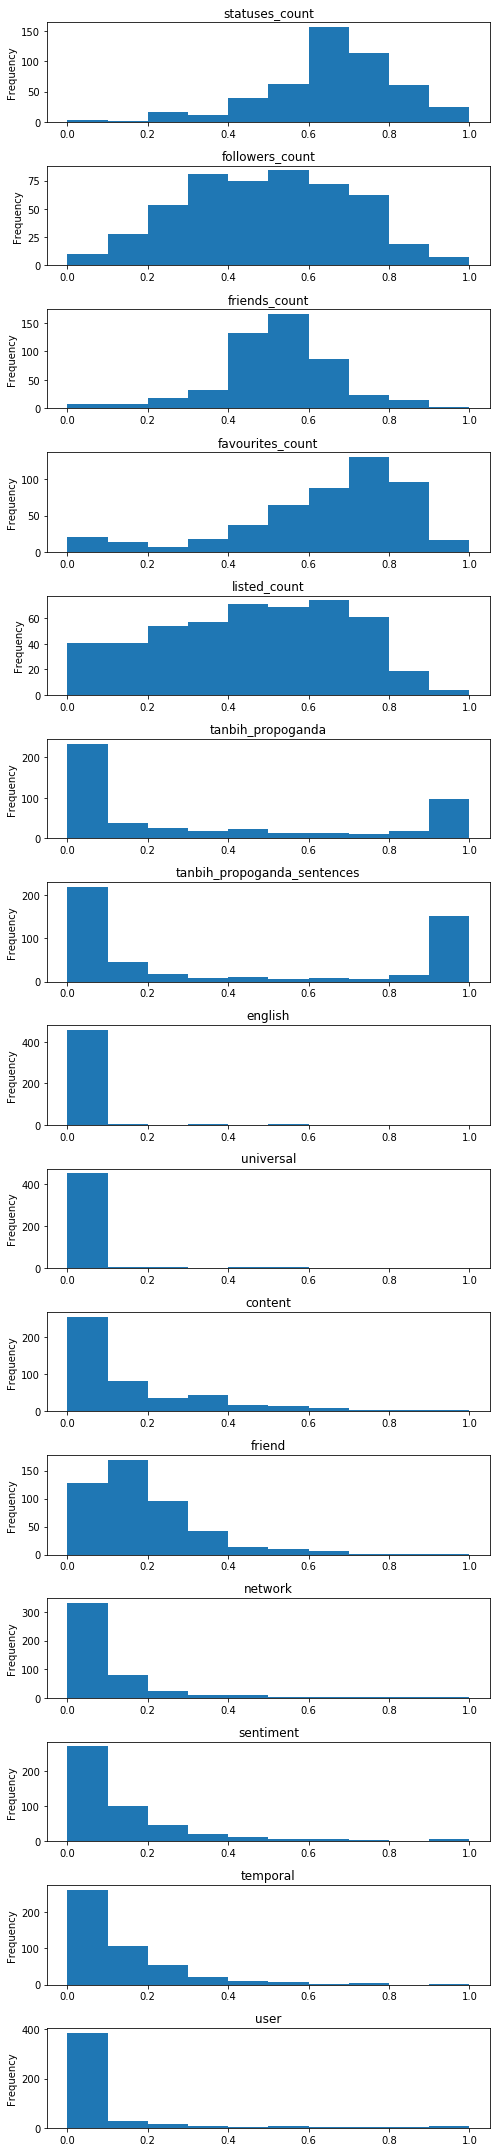

In [6]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

fig, axs = plt.subplots(len(numerical_features), figsize=(7, 30))

for idx, f in enumerate(numerical_features):
    print(f)
    pd.Series(minmax_scale(np.log(features[f] + 1))).plot.hist(ax=axs.flatten()[idx])
    axs.flatten()[idx].set_title(f)
    
plt.tight_layout()

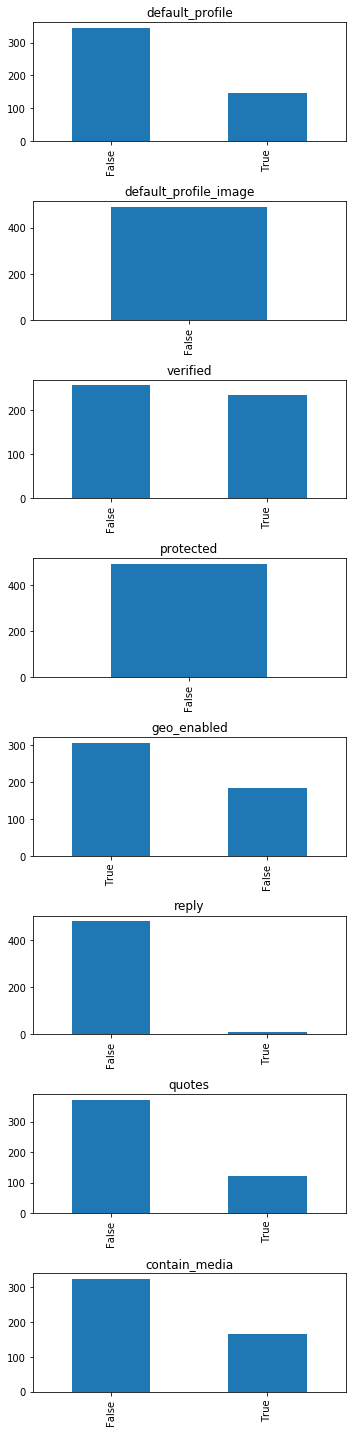

In [17]:
fig, axs = plt.subplots(len(bool_features), figsize=(5, 20))
for idx, f in enumerate(bool_features):
    features[f].value_counts().plot(kind='bar', ax=axs[idx])
    axs.flatten()[idx].set_title(f)
    
plt.tight_layout()

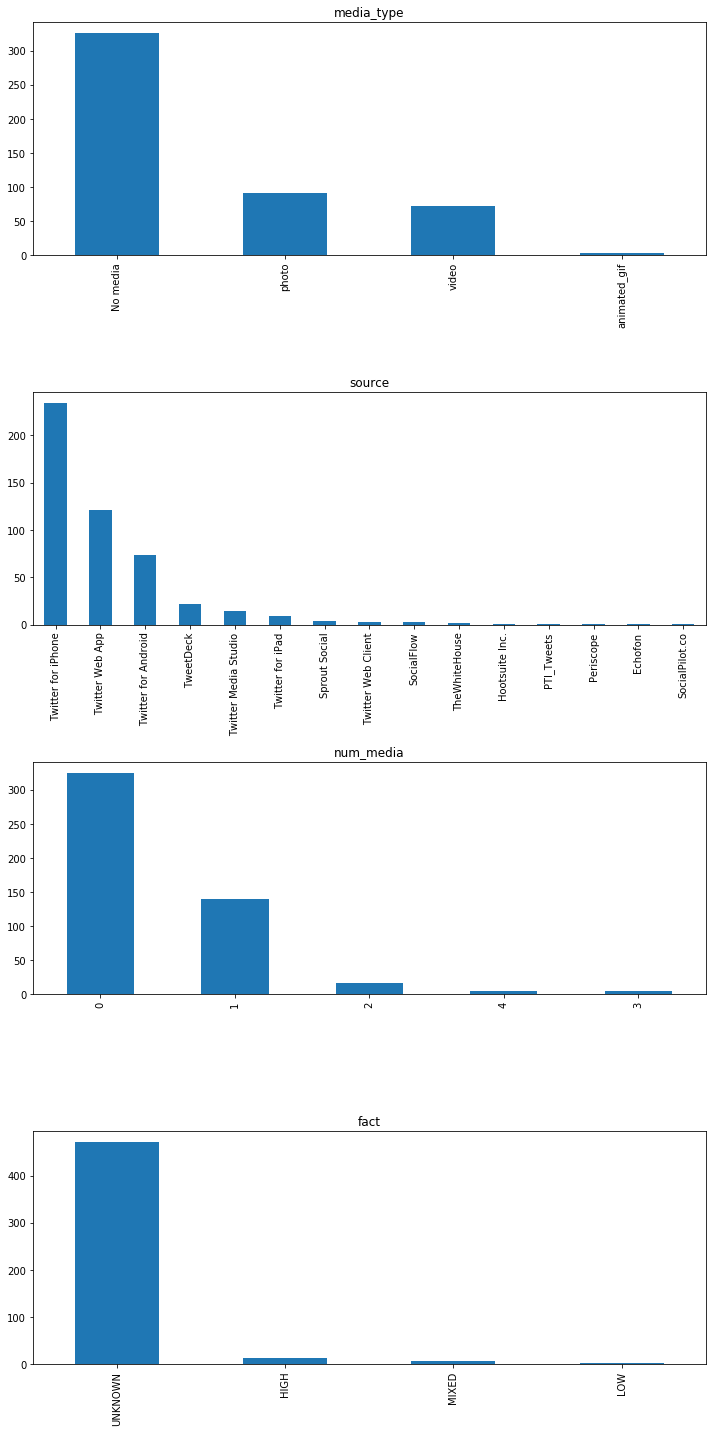

In [18]:
# add domain after discussing with team
fig, axs = plt.subplots(len(cat_features), figsize=(10, 20))
for idx, f in enumerate(cat_features):
    features[f].value_counts().plot(kind='bar', ax=axs[idx])
    axs.flatten()[idx].set_title(f)
    
plt.tight_layout()

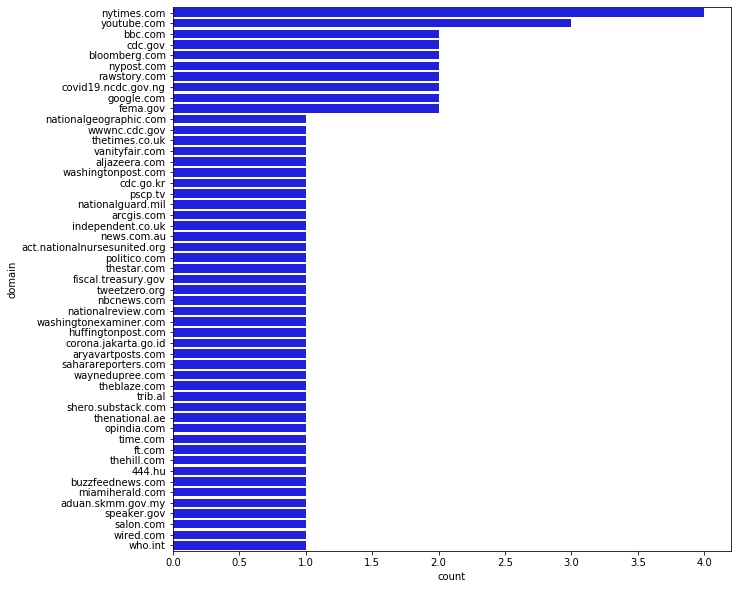

In [19]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))

# features['domain'].value_counts().plot(kind='bar', ax=ax)

domain_counts = features['domain'].value_counts().reset_index()
domain_counts.columns = ['domain', 'count']
domain_counts['count'] = domain_counts['count'].astype(int)

sns.barplot(x='count', y='domain', data=domain_counts, ax=ax, color='blue')

# Features to ML input

In [10]:
from sklearn.pipeline import Pipeline as pipe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

import feature_engine.missing_data_imputers as mdi


class column_selector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        return X_[self.variables]

class add_one(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.variables] = X_[self.variables] + 1
        return X_
    
# returns pandas instead of numpy
class pd_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.scaler = MinMaxScaler()
        return
    def fit(self, X, y=None):
        self.scaler.fit(X[self.variables])
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_[self.variables] = self.scaler.transform(X_[self.variables])
        return X_

# set up the pipeline
features_to_ml_pipe = pipe([
 ('column_selector', column_selector(variables=bool_features+
                                     cat_features+
                                     numerical_features+
                                     nonnormalized_numerical_features)),
 ('categorical_encoder', ce.OneHotCategoricalEncoder(variables=cat_features, drop_last=False)),
 ('continuous_var_median_imputer', mdi.MeanMedianImputer(imputation_method='median', variables=numerical_features)),
 ('add_one_to_numerical_features', add_one(numerical_features)),
 ('log_transformer', vt.LogTransformer(base='e', variables=numerical_features)),
 ('scaler', pd_scaler(variables=numerical_features))
])



In [11]:
ml = features_to_ml_pipe.fit(features).transform(features)

In [12]:
ml.dtypes

default_profile                   bool
default_profile_image             bool
verified                          bool
protected                         bool
geo_enabled                       bool
reply                             bool
quotes                            bool
contain_media                     bool
statuses_count                 float64
followers_count                float64
friends_count                  float64
favourites_count               float64
listed_count                   float64
tanbih_propoganda              float64
tanbih_propoganda_sentences    float64
english                        float64
universal                      float64
content                        float64
friend                         float64
network                        float64
sentiment                      float64
temporal                       float64
user                           float64
year_user_created                int64
media_type_No media              int32
media_type_photo         

# Save ML

In [13]:
ml

,default_profile,default_profile_image,verified,protected,geo_enabled,reply,quotes,contain_media,statuses_count,followers_count,...,source_Hootsuite Inc.,num_media_0,num_media_1,num_media_2,num_media_3,num_media_4,fact_UNKNOWN,fact_LOW,fact_MIXED,fact_HIGH
id,,,,,,,,,,,,,,,,,,,,,
1241025578527903750,False,False,False,False,False,False,False,False,0.600106,0.328851,...,0,1,0,0,0,0,1,0,0,0
1240467080954228737,True,False,False,False,False,False,True,False,0.225843,0.429730,...,0,1,0,0,0,0,1,0,0,0
1240716889162018816,True,False,False,False,True,False,False,False,0.673990,0.293723,...,0,1,0,0,0,0,1,0,0,0
1241062514886090754,False,False,False,False,False,False,True,False,0.632101,0.238643,...,0,1,0,0,0,0,1,0,0,0
1241447017945223169,False,False,False,False,False,False,False,True,0.825378,0.443016,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235831463121059840,False,False,False,False,False,True,True,False,0.806139,0.628478,...,0,1,0,0,0,0,1,0,0,0
1235967176475111432,False,False,True,False,True,False,True,False,0.626831,0.521253,...,0,1,0,0,0,0,1,0,0,0
1236056191324864515,True,False,True,False,True,False,False,False,0.560902,0.485435,...,0,1,0,0,0,0,0,0,0,1


In [14]:
ml.columns

Index(['default_profile', 'default_profile_image', 'verified', 'protected',
       'geo_enabled', 'reply', 'quotes', 'contain_media', 'statuses_count',
       'followers_count', 'friends_count', 'favourites_count', 'listed_count',
       'tanbih_propoganda', 'tanbih_propoganda_sentences', 'english',
       'universal', 'content', 'friend', 'network', 'sentiment', 'temporal',
       'user', 'year_user_created', 'media_type_No media', 'media_type_photo',
       'media_type_video', 'media_type_animated_gif',
       'source_Twitter for iPhone', 'source_Twitter for Android',
       'source_Twitter Web App', 'source_Twitter Media Studio',
       'source_TweetDeck', 'source_Periscope', 'source_TheWhiteHouse',
       'source_Echofon', 'source_Twitter for iPad', 'source_Sprout Social',
       'source_Twitter Web Client', 'source_SocialPilot.co',
       'source_PTI_Tweets', 'source_SocialFlow', 'source_Hootsuite Inc.',
       'num_media_0', 'num_media_1', 'num_media_2', 'num_media_3',
       'nu

In [1336]:
from joblib import dump, load

ml.to_csv(lang + 'data/features_' + lang.lower() + '.tsv', sep='\t', index=True)
dump(features_to_ml_pipe, 'features_to_ml_pipe.joblib') 